In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import mysql.connector
import datetime
import math
from scipy import stats
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler
import mysql.connector
from scipy.stats import ttest_ind
import csv

In [2]:
username = 'root'
user_password = 'Sadegh74'
db_name = 'superstore'

In [3]:
cnx = mysql.connector.connect(
    user=username,
    password=user_password,
    host='localhost',
    database=db_name
)

In [4]:
query = "SELECT * FROM order_detail;"
df = pd.read_sql(query, con=cnx)
df.head()

,Row ID,Order ID,Product ID,Sales,Quantity,Discount,Profit,Shipping Cost
0,1,MX-2014-143658,OFF-LA-10002782,13.08,3,0.0,4.56,1.033
1,2,MX-2012-155047,FUR-FU-10004015,252.16,8,0.0,90.72,13.449
2,3,MX-2012-155047,FUR-BO-10002352,193.28,2,0.0,54.08,9.627
3,4,MX-2012-155047,OFF-BI-10004428,35.44,4,0.0,4.96,1.371
4,5,MX-2012-155047,OFF-AR-10004594,71.60,2,0.0,11.44,3.787


In [5]:
w_dis = df[df['Discount'] != 0]
wo_dis = df[df['Discount'] == 0]

In [26]:
w = w_dis.groupby('Product ID')['Quantity'].sum().reset_index()
wo = wo_dis.groupby('Product ID')['Quantity'].sum().reset_index()
col_name = ['Product ID','Quantity']
w.columns = col_name
wo.columns = col_name
wo = wo[wo['Product ID'].isin(w['Product ID'])].sort_values(by='Product ID')
w = w[w['Product ID'].isin(wo['Product ID'])].sort_values(by='Product ID')
merged_df = pd.merge(w, wo, on='Product ID', how='inner')
col_name = ['Product ID','with_discount','without_discount']
merged_df.columns = col_name
merged_df

,Product ID,with_discount,without_discount
0,FUR-ADV-10000183,20,11
1,FUR-ADV-10000188,3,4
2,FUR-ADV-10001283,2,1
3,FUR-ADV-10001659,2,8
4,FUR-ADV-10001855,1,3
...,...,...,...
6533,TEC-STA-10003447,1,7
6534,TEC-STA-10003550,1,13
6535,TEC-STA-10003925,2,6
6536,TEC-STA-10004181,1,10


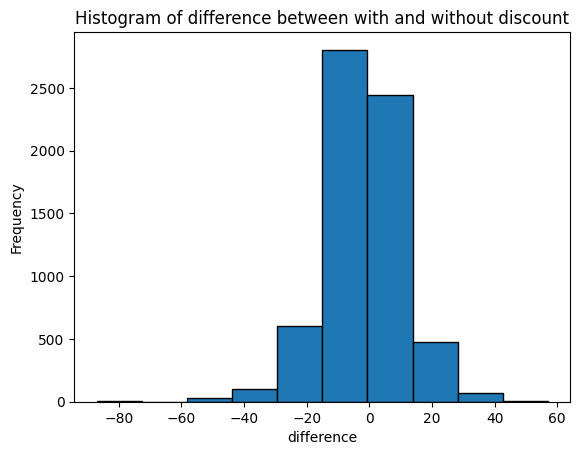

In [35]:
merged_df['dif'] = merged_df['with_discount'] - merged_df['without_discount']
plt.hist(merged_df['dif'], edgecolor='black')
plt.xlabel('difference')
plt.ylabel('Frequency')
plt.title('Histogram of difference between with and without discount')
plt.savefig('Histogram.png')
plt.show()

In [32]:
t_statistic, p_value = stats.ttest_1samp(merged_df['dif'], 0)

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


In [33]:
w_statistic, p_value = stats.wilcoxon(merged_df['dif'])
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


In [6]:
t_statistic, p_value = stats.ttest_ind(w_dis['Quantity'], wo_dis['Quantity'])

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


In [15]:
output = {}
output['No. Discounted'] = len(w_dis)
output['No. Without Discount'] = len(wo_dis)
output['hypothesis'] = 'The average quantity of discounted orders is same to the average quantity of non-discounted orders.'
output['t_statistic'] = t_statistic
output['p_value'] = p_value
output['alpha'] = alpha
output['result'] = 'Reject the Hypothesis' if p_value < alpha else 'Fail to Reject the Hypothesis'
output = pd.DataFrame(output, index=[0])
output

,No. Discounted,No. Without Discount,hypothesis,t_statistic,p_value,alpha,result
0,21567,28103,The average quantity of discounted orders is s...,8.392667,4.875845e-17,0.05,Reject the Hypothesis
